# Face Verification System Evaluation

The reliability of a face verification system depends on various factors, including the quality of the data, the algorithms used, and the implementation.


## 1. Data Collection

Currently available:

-   1. LFW dataset
-   2. RFW dataset


### LFW Dataset

Labeled Face in the Wild is a public benchmark for face verification, also known as pair matching. No matter what the performance of an algorithm on LFW, it should not be used to conclude that an algorithm is suitable for any commercial purpose.

-   Face verification and other forms of face recognition are very different problems. For example, it is very difficult to extrapolate from performance on verification to performance on 1:N recognition.
-   Many groups are not well represented in LFW. For example, there are very few children, no babies, very few people over the age of 80, and a relatively small proportion of women. In addition, many ethnicities have very minor representation or none at all.
-   While theoretically LFW could be used to assess performance for certain subgroups, the database was not designed to have enough data for strong statistical conclusions about subgroups. Simply put, LFW is not large enough to provide evidence that a particular piece of software has been thoroughly tested.
-   Additional conditions, such as poor lighting, extreme pose, strong occlusions, low resolution, and other important factors do not constitute a major part of LFW. These are important areas of evaluation, especially for algorithms designed to recognize images “in the wild”.

The data set contains more than **13,000** images of faces collected from the web.Each face has been labeled with the name of the person pictured. **1680** of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector.

**Threshold Values within DeepFace**
- The concern about this threshold value is there is no reference about how they obtained these value, so I think it might be the best if we get the threshold value ourselves. So, we can provide the reasons for them.
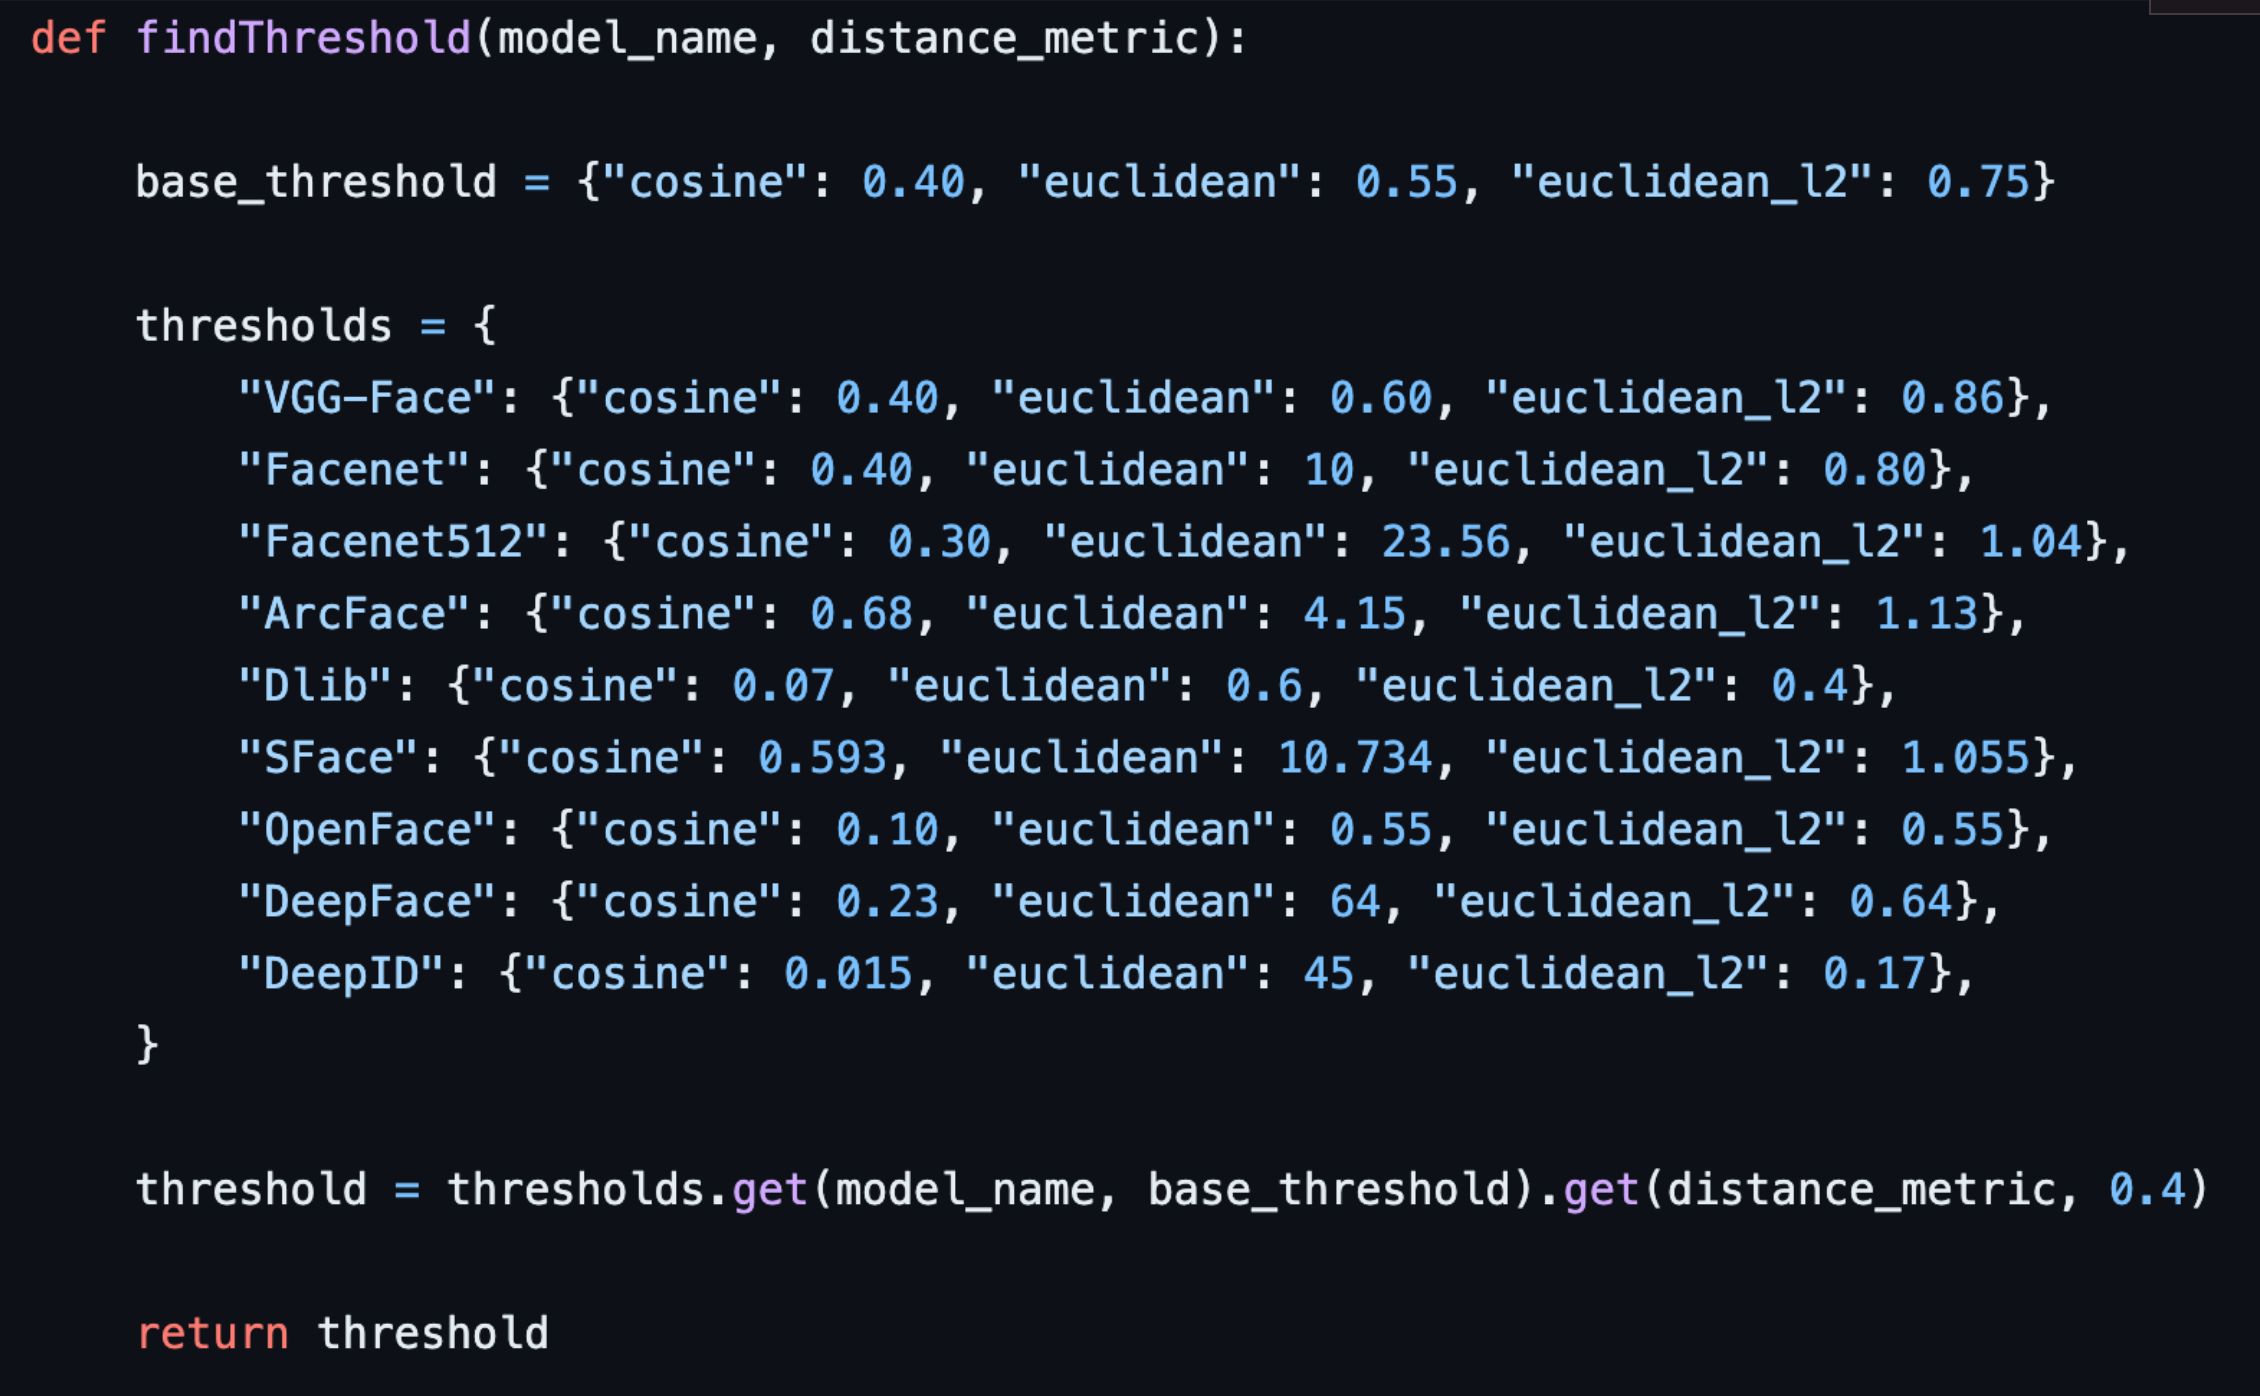

**Accuracy**
- *DeepFace* provided the table of accuracy for each model. However, they stated that these accuracies are based on its creator / papers. So, there may be some differences in evaluation, I would like to do evaluation myself on interested models to ensure that I got the right evaluation results of the models across multiple datasets.
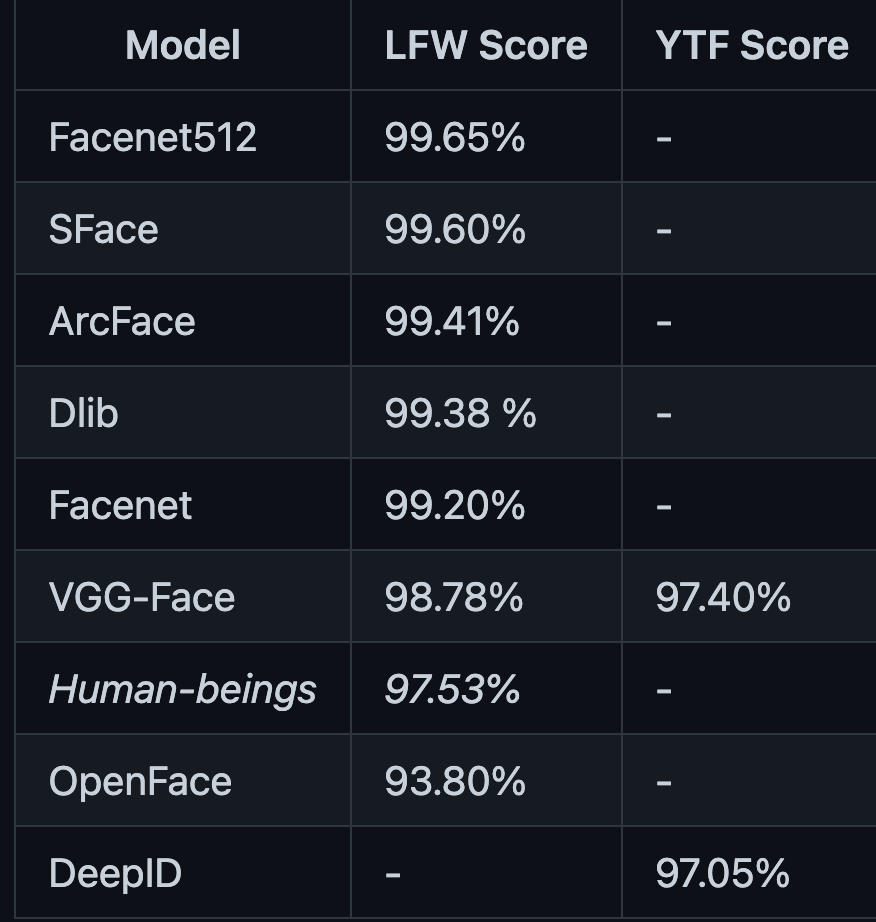

#### Imports

In [9]:
import os
import numpy as np
from deepface import DeepFace
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

#### Define dataset path

In [2]:
# Define the path to the LFW dataset and pairs.txt file
lfw_dir = "./database/lfw"
pairs_file = "./database/lfw_pairs.txt"

#### Define functions

In [15]:
def read_pairs_file(
    pairs_file,
    lfw_dir,
    face_detector="opencv",
    face_recognizer="VGG-Face",
    distance_metric="cosine",
):
    """
    Read lfw_pairs.txt file and extract information about matched and mismatched pairs
    params:
        pairs_file: path to the lfw_pairs.txt file
        lfw_dir: path to the LFW dataset
        face_detector: face detector backend to use
        face_recognizer: face recognition model to use
        distance_metric: distance metric to use
    return:
        y_true: true labels (1 for matched pairs, 0 for mismatched pairs)
        y_distances: distances from the DeepFace model
    """
    y_true = []  # True labels (1 for matched pairs, 0 for mismatched pairs)
    y_distances = []  # distances from the DeepFace model

    with open(pairs_file, "r") as f:
        num_sets, num_pairs_per_set = map(int, f.readline().strip().split())
        num_pairs_per_set = 2 * num_pairs_per_set  # matched and mismatched pairs each set has the same number of pairs
        for _ in tqdm(range(num_sets)):
            for _ in tqdm(range(num_pairs_per_set)):
                line = f.readline().strip().split()
                if len(line) == 3:  # Matched pair format: name n1 n2
                    name, n1, n2 = line
                    img1_path = os.path.join(lfw_dir, name, f"{name}_{n1.zfill(4)}.jpg")
                    img2_path = os.path.join(lfw_dir, name, f"{name}_{n2.zfill(4)}.jpg")
                    y_true.append(1)  # Matched pair
                elif len(line) == 4:  # Mismatched pair format: name1 n1 name2 n2
                    name1, n1, name2, n2 = line
                    img1_path = os.path.join(
                        lfw_dir, name1, f"{name1}_{n1.zfill(4)}.jpg"
                    )
                    img2_path = os.path.join(
                        lfw_dir, name2, f"{name2}_{n2.zfill(4)}.jpg"
                    )
                    y_true.append(0)  # Mismatched pair

                # Load and compare the images using DeepFace
                result = DeepFace.verify(
                    img1_path=img1_path,
                    img2_path=img2_path,
                    model_name=face_recognizer,
                    detector_backend=face_detector,
                    distance_metric=distance_metric,
                    enforce_detection=False,
                    align=True,
                    normalization="base",
                )

                # Store the distance (similarity) score from the DeepFace model
                y_distances.append(result["distance"])

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_distances = np.array(y_distances)

    return y_true, y_distances

def plot_roc_auc(y_true, y_distances, face_recognizer):
    fpr, tpr, thresholds = roc_curve(y_true, -y_distances)  # Note the negation of distances
    roc_auc = auc(fpr, tpr)

    hovertext = [f'Threshold: {threshold:.2f}' for threshold in thresholds]

    fig = px.area(
        x=fpr,
        y=tpr,
        title=f'ROC AUC Curve (AUC={roc_auc:.2f}), {face_recognizer}',
        labels={'x': 'False Positive Rate', 'y': 'True Positive Rate'},
        hover_name=hovertext,
    )
    fig.add_shape(
        type='line',
        line=dict(dash='dash'),
        x0=0,
        x1=1,
        y0=0,
        y1=1,
        line_color='navy',
    )
    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

    fig.show()

def evaluate(y_true, y_distances, threshold=0.4):
    """
    Calculate evaluation metrics
    params:
        y_true: true labels (1 for matched pairs, 0 for mismatched pairs)
        y_distances: distances from the DeepFace model
        threshold: threshold to use for classification
    return:
        accuracy: accuracy score
        cm: confusion matrix
        tn: true negatives
        fp: false positives
        fn: false negatives
        tp: true positives
    """
    y_preds = (y_distances < threshold).astype(int)
    accuracy = accuracy_score(y_true, y_preds)
    cm = confusion_matrix(y_true, y_preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    # Print and report the evaluation metrics
    print(f"Threshold: {threshold:.2f}")
    print(f"Total number of pairs: {len(y_true)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"TPR: {tpr:.4f}")
    print(f"FPR: {fpr:.4f}")

    
    return accuracy, cm, tn, fp, fn, tp, tpr, fpr


def save_and_plot_output(face_detector, face_recognizer, distance_metric, threshold, output_dir="./evaluation_result"):
    y_true = np.load(f"{output_dir}/baseline_labels_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy")
    y_distances = np.load(f"{output_dir}/baseline_distances_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy")

    accuracy, cm, tn, fp, fn, tp, tpr, fpr  = evaluate(y_true, y_distances, threshold=threshold)

    # Define the path to the output file
    os.makedirs(output_dir, exist_ok=True)
    output_file = f"{output_dir}/baseline_results_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.txt"
    plot_roc_auc(y_true, y_distances, face_recognizer)
    
    # Create a pandas DataFrame to store the evaluation metrics
    data = {
        "Face Detector": [face_detector],
        "Face Recognizer": [face_recognizer],
        "Distance Metric": [distance_metric],
        "Threshold": [threshold],
        "Accuracy": [accuracy],
        "Confusion Matrix": [cm],
        "True Negatives": [tn],
        "False Positives": [fp],
        "False Negatives": [fn],
        "True Positives": [tp],
        "Precision": [tp / (tp + fp)],
        "Recall": [tp / (tp + fn)],
        "TPR": [tpr],
        "FPR": [fpr]
    }
    df = pd.DataFrame(data)
    
    # Save the evaluation metrics as a pandas DataFrame
    output_file = f"{output_dir}/baseline_results_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.csv"
    df.to_csv(output_file, index=False)
    
    return df


#### For interested models, I select:
- VGG-FACE
- Facenet
- Facenet512
- ArcFace
- SFace

The first step is finding the baseline of evaluation

#### Perform verification on dataset

In [8]:
# Define what face detector, face recognizer, distance metric and threshold value to use
face_detector = "yunet"
face_recognizers = ["Facenet", "Facenet512", "ArcFace", "SFace"]
# face_recognizers = ["VGG-Face"]
distance_metric = "cosine"
thresholds = {
    "VGG-Face": 0.4,
    "Facenet": 0.4,
    "Facenet512": 0.3,
    "ArcFace": 0.68,
    "SFace": 0.593,
}

for face_recognizer in tqdm(face_recognizers):
    threshold = thresholds[face_recognizer]
    # Define the path to the output file
    output_file = f"./evaluation_result/baseline_results_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.txt"

    # Read pairs.txt file and extract information about matched and mismatched pairs
    y_true, y_distances = read_pairs_file(
        pairs_file,
        lfw_dir,
        face_detector=face_detector,
        face_recognizer=face_recognizer,
        distance_metric=distance_metric,
    )

    # save the labels and distances to a file
    target_dir = "./face_recognition_evaluation_result"
    os.makedirs(target_dir, exist_ok=True)
    np.save(f"{target_dir}/baseline_labels_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy", y_true)
    np.save(f"{target_dir}/baseline_distances_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy", y_distances)



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

In [28]:
y_distances

array([0.39828736, 0.11741956, 0.18732842, ..., 0.72053962, 1.03492609,
       0.77462463])

#### Evaluate, print, plot and save results

In [18]:
# Define the parameters
face_detector = "yunet"
face_recognizers = ["VGG-Face", "Facenet", "Facenet512", "ArcFace", "SFace"]
distance_metric = "cosine"
thresholds = {
    "VGG-Face": 0.4,
    "Facenet": 0.4,
    "Facenet512": 0.3,
    "ArcFace": 0.68,
    "SFace": 0.593,
}
# Define the list to store all the dataframes
dataframes = []

# Loop through the face recognizers
for face_recognizer in tqdm(face_recognizers):
    try:
        print(f"Face Recognizer: {face_recognizer}")
        threshold = thresholds[face_recognizer]
        df = save_and_plot_output(face_detector, face_recognizer, distance_metric, threshold, output_dir=target_dir)
        dataframes.append(df)
    except:
        pass

# Combine all the dataframes into one dataframe
combined_df = pd.concat(dataframes)

# Save the combined dataframe as a CSV file
combined_df.to_csv(os.path.join(target_dir, "combined_results.csv"), index=False)


  0%|          | 0/5 [00:00<?, ?it/s]

Face Recognizer: VGG-Face
Threshold: 0.40
Total number of pairs: 6000
Accuracy: 0.8340
Confusion Matrix:
[[2122  878]
 [ 118 2882]]
True Positives: 2882
True Negatives: 2122
False Positives: 878
False Negatives: 118
Precision: 0.7665
Recall: 0.9607
TPR: 0.9607
FPR: 0.2927


Face Recognizer: Facenet
Threshold: 0.40
Total number of pairs: 6000
Accuracy: 0.8130
Confusion Matrix:
[[2994    6]
 [1116 1884]]
True Positives: 1884
True Negatives: 2994
False Positives: 6
False Negatives: 1116
Precision: 0.9968
Recall: 0.6280
TPR: 0.6280
FPR: 0.0020


Face Recognizer: Facenet512
Threshold: 0.30
Total number of pairs: 6000
Accuracy: 0.7602
Confusion Matrix:
[[2999    1]
 [1438 1562]]
True Positives: 1562
True Negatives: 2999
False Positives: 1
False Negatives: 1438
Precision: 0.9994
Recall: 0.5207
TPR: 0.5207
FPR: 0.0003


Face Recognizer: ArcFace
Threshold: 0.68
Total number of pairs: 6000
Accuracy: 0.9262
Confusion Matrix:
[[2956   44]
 [ 399 2601]]
True Positives: 2601
True Negatives: 2956
False Positives: 44
False Negatives: 399
Precision: 0.9834
Recall: 0.8670
TPR: 0.8670
FPR: 0.0147


Face Recognizer: SFace
Threshold: 0.59
Total number of pairs: 6000
Accuracy: 0.7190
Confusion Matrix:
[[2976   24]
 [1662 1338]]
True Positives: 1338
True Negatives: 2976
False Positives: 24
False Negatives: 1662
Precision: 0.9824
Recall: 0.4460
TPR: 0.4460
FPR: 0.0080


In [19]:
combined_df

,Face Detector,Face Recognizer,Distance Metric,Threshold,Accuracy,Confusion Matrix,True Negatives,False Positives,False Negatives,True Positives,Precision,Recall,TPR,FPR
0,yunet,VGG-Face,cosine,0.400,0.834000,"[[2122, 878], [118, 2882]]",2122,878,118,2882,0.766489,0.960667,0.960667,0.292667
0,yunet,Facenet,cosine,0.400,0.813000,"[[2994, 6], [1116, 1884]]",2994,6,1116,1884,0.996825,0.628000,0.628000,0.002000
0,yunet,Facenet512,cosine,0.300,0.760167,"[[2999, 1], [1438, 1562]]",2999,1,1438,1562,0.999360,0.520667,0.520667,0.000333
0,yunet,ArcFace,cosine,0.680,0.926167,"[[2956, 44], [399, 2601]]",2956,44,399,2601,0.983365,0.867000,0.867000,0.014667
0,yunet,SFace,cosine,0.593,0.719000,"[[2976, 24], [1662, 1338]]",2976,24,1662,1338,0.982379,0.446000,0.446000,0.008000


#### ROC Curve
[Trueface Tutorials Understanding ROC Curves
](https://medium.com/trueface-ai/what-are-roc-curves-and-how-to-interpret-them-d53b09c06b81)

##### Note

In [ ]:
# # Evaluate the model performance according to the cross-validation scheme
# NUMBER_OF_FOLDS = 10
# NUMBER_OF_SETS_PER_FOLD = 600
# output_file = f"./cross_evaluation_result/baseline_results_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.txt"
# sum_accuracy = 0
# sum_cm = np.zeros((2,2))
# sum_tn = 0
# sum_fp = 0
# sum_fn = 0
# sum_tp = 0
# sum_precision = 0
# sum_recall = 0
# for i in tqdm(range(NUMBER_OF_FOLDS)):
#     print(f"Fold {i+1}")
#     y_true_fold = y_true[i*NUMBER_OF_SETS_PER_FOLD:(i+1)*NUMBER_OF_SETS_PER_FOLD]
#     y_distances_fold = y_distances[i*NUMBER_OF_SETS_PER_FOLD:(i+1)*NUMBER_OF_SETS_PER_FOLD]
#     accuracy, cm, tn, fp, fn, tp, tpr, fpr = evaluate(y_true_fold, y_distances_fold, threshold=threshold)
#     precision = tp / (tp + fp)
#     recall = tp / (tp + fn)
#     sum_accuracy += accuracy
#     sum_cm += cm
#     sum_tn += tn
#     sum_fp += fp
#     sum_fn += fn
#     sum_tp += tp
#     sum_precision += precision
#     sum_recall += recall
#     with open(output_file, "a") as f:
#         f.write(f"Fold {i+1}\n")
#         f.write(f"Threshold: {threshold:.2f}\n")
#         f.write(f"Total number of pairs: {len(y_true_fold)}\n")
#         f.write(f"Accuracy: {accuracy:.4f}\n")
#         f.write(f"Confusion Matrix:\n{cm}\n")
#         f.write(f"True Positives: {tp}\n")
#         f.write(f"True Negatives: {tn}\n")
#         f.write(f"False Positives: {fp}\n")
#         f.write(f"False Negatives: {fn}\n")
#         f.write(f"Precision: {precision:.4f}\n")
#         f.write(f"Recall: {recall:.4f}\n")
#         f.write("============\n")
# with open(output_file, "a") as f:
#     f.write(f"Mean classification accuracy: {sum_accuracy/NUMBER_OF_FOLDS:.4f}\n")
#     f.write(f"Mean confusion matrix:\n{sum_cm/NUMBER_OF_FOLDS}\n")
#     f.write(f"Mean true positives: {sum_tp/NUMBER_OF_FOLDS}\n")
#     f.write(f"Mean true negatives: {sum_tn/NUMBER_OF_FOLDS}\n")
#     f.write(f"Mean false positives: {sum_fp/NUMBER_OF_FOLDS}\n")
#     f.write(f"Mean false negatives: {sum_fn/NUMBER_OF_FOLDS}\n")
#     f.write(f"Mean precision: {sum_precision/NUMBER_OF_FOLDS:.4f}\n")
#     f.write(f"Mean recall: {sum_recall/NUMBER_OF_FOLDS:.4f}\n")
#     f.write(f"Mean TPR: {sum_tp/(sum_tp+sum_fn):.4f}\n")
#     f.write(f"Mean FPR: {sum_fp/(sum_fp+sum_tn):.4f}\n")
#     f.write("============\n")

In [12]:
# Calculate evaluation metrics
# accuracy, cm, tn, fp, fn, tp, tpr, fpr  = evaluate(y_true, y_distances, threshold=threshold)

# Save the evaluation metrics to a file
# with open(output_file, "w") as f:
#     f.write("Baseline Model Evaluation\n")
#     f.write(f"Face Detector: {face_detector}\n")
#     f.write(f"Face Recognizer: {face_recognizer}\n")
#     f.write(f"Distance Metric: {distance_metric}\n")
#     f.write(f"Threshold: {threshold}\n")
#     f.write(f"Accuracy: {accuracy:.4f}\n")
#     f.write(f"Confusion Matrix:\n{cm}\n")
#     f.write(f"True Negatives: {tn}\n")
#     f.write(f"False Positives: {fp}\n")
#     f.write(f"False Negatives: {fn}\n")
#     f.write(f"True Positives: {tp}\n")
#     f.write(f"Precision: {(tp / (tp + fp)):.4f}\n")
#     f.write(f"Recall: {(tp / (tp + fn)):.4f}\n")

# # Save labels and distances to a file
# np.save(f"./evaluation_result/baseline_labels_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy", y_true)
# np.save(f"./evaluation_result/baseline_distances_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy", y_distances)


Fine-tune threshold value for each model
- We will classify two face photos as same person if the distance is less than a threshold value. 

- It allows you to adapt the model's decision boundary to align with the specific requirements and goals of your application.

- Balancing Precision and Recall: The threshold determines the trade-off between precision and recall. A higher threshold increases precision but may lower recall, while a lower threshold increases recall but may lower precision. Precision answers the how many of my positive predictions are correct. Recall answers how many of actual positives are predicted correctly.

In [13]:
# # use saved true labels and distances to fine tune threshold value
# face_detector = "opencv"
# face_recognizer = "SFace"
# distance_metric = "cosine"
# threshold = 0.593
# y_true = np.load(f"./evaluation_result/baseline_labels_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy")
# y_distances = np.load(f"./evaluation_result/baseline_distances_{face_detector}_{face_recognizer}_{distance_metric}_{threshold}.npy")

# # Fine-tune threshold value according to the cross-validation scheme
# NUMBER_OF_FOLDS = 10
# NUMBER_OF_SETS_PER_FOLD = 600

# # Define the range of threshold values to search within (0 to 1 with a step of 0.01)
# threshold_values = np.arange(0.0, 1.01, 0.01)

# # Initialize variables to store the best threshold and best accuracy
# best_threshold = None
# best_accuracy = 0.0

# for i in tqdm(range(NUMBER_OF_FOLDS)):
#     y_true_fold = y_true[i*NUMBER_OF_SETS_PER_FOLD:(i+1)*NUMBER_OF_SETS_PER_FOLD]
#     y_distances_fold = y_distances[i*NUMBER_OF_SETS_PER_FOLD:(i+1)*NUMBER_OF_SETS_PER_FOLD]
#     for threshold in threshold_values:
#         accuracy, cm, tn, fp, fn, tp = evaluate(y_true_fold, y_distances_fold, threshold=threshold)
#         if accuracy > best_accuracy:
#             best_threshold = threshold
#             best_accuracy = accuracy
# # Print the best threshold and its corresponding best accuracy
# print(f"Best Threshold: {best_threshold:.2f}")
# print(f"Best Accuracy: {best_accuracy:.4f}")

# # Calculate evaluation metrics
# accuracy, cm, tn, fp, fn, tp  = evaluate(y_true, y_distances, threshold=best_threshold)

# # Save the evaluation metrics to a file
# output_file = f"./evaluation_fine_tune_result/fine_tune_results_{face_detector}_{face_recognizer}_{distance_metric}_{best_threshold}.txt"

# with open(output_file, "w") as f:
#     f.write("Fine-tune threshold Evaluation\n")
#     f.write(f"Face Detector: {face_detector}\n")
#     f.write(f"Face Recognizer: {face_recognizer}\n")
#     f.write(f"Distance Metric: {distance_metric}\n")
#     f.write(f"Threshold: {best_threshold}\n")
#     f.write(f"Accuracy: {accuracy:.4f}\n")
#     f.write(f"Confusion Matrix:\n{cm}\n")
#     f.write(f"True Negatives: {tn}\n")
#     f.write(f"False Positives: {fp}\n")
#     f.write(f"False Negatives: {fn}\n")
#     f.write(f"True Positives: {tp}\n")
#     f.write(f"Precision: {(tp / (tp + fp)):.4f}\n")
#     f.write(f"Recall: {(tp / (tp + fn)):.4f}\n")